In [1]:
from google.colab import userdata
!pip install -qU "langchain-community>=0.2.11" tavily-python
key = userdata.get('TAVILY_API_KEY')
import subprocess
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = key
def check_and_install(package_name):
    try:
        subprocess.check_output(['pip', 'show', package_name])
    except subprocess.CalledProcessError:
        print(f"{package_name} not found, installing...")
        subprocess.check_output(['pip', 'install', package_name])
    else:
        print(f"{package_name} already installed.")

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')

check_and_install('langchain_community')
check_and_install('langchain')
check_and_install('openai')
check_and_install('python-dotenv')
check_and_install('tiktoken')
check_and_install('langchain_openai')
check_and_install('google-colab')
check_and_install('langgraph')
check_and_install('chromadb')
check_and_install('langchain_experimental')
!pip install --upgrade langchain
!pip install langgraph
!pip install chromadb

oai_key = userdata.get('OPENAI_API_KEY')

Running on CoLab
langchain_community already installed.
langchain already installed.
openai already installed.
python-dotenv already installed.
tiktoken already installed.
langchain_openai already installed.
google-colab already installed.
langgraph already installed.
chromadb already installed.
langchain_experimental already installed.


In [2]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

In [3]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatOpenAI(temperature=0, model="gpt-4o",api_key=oai_key)


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [4]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

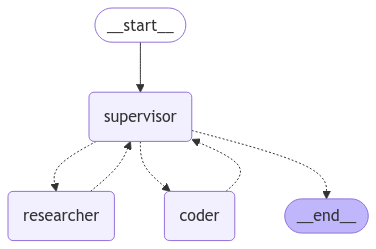

In [5]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:2730ea43-4d64-06c8-82f8-3219172bad52',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5g4P3Tij0MPcQi9Q3WeFWxWO', 'function': {'arguments': '{"query": "latest GDP of New York 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_Zlu95Y2WLxAAN1CyzBZAcYqx', 'function': {'arguments': '{"query": "latest GDP of California 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 104, 'total_tokens': 170, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-dcf3761a-139e

(('coder:13b68fc2-3b10-421a-e6a2-48ee1a844b68',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gRJjW2BjviAjvxWDNg2qRe1w', 'function': {'arguments': '{"code":"# Given GDP values for New York and California\\nny_gdp = 2.172  # in trillion dollars\\nca_gdp = 3.9    # in trillion dollars\\n\\n# Calculate the average GDP\\naverage_gdp = (ny_gdp + ca_gdp) / 2\\naverage_gdp"}', 'name': 'python_repl_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 167, 'total_tokens': 248, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-662d2bd6-c2dd-41cd-aed1-11287b4f854b-0', tool_calls=[{'name': 'pytho

In [8]:
from langchain_core.messages import BaseMessage


teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

NameError: name 'make_supervisor_node' is not defined

In [7]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

NameError: name 'teams_supervisor_node' is not defined